In [0]:
import pandas as pd
import numpy as np
import string
import io
import tensorflow as tf

In [3]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [4]:
# Create character mapping
df = pd.read_csv(io.StringIO(uploaded['data.csv'].decode('utf-8')))
regions = list(set(df['region']))
df['city'] = df['city'] + '|' # EOL character
n_regions = len(regions)

chars = sorted(list(set(df['city'].to_string())))
char_indices = dict((c, i+1) for i, c in enumerate(chars))
indices_char = dict((i+1, c) for i, c in enumerate(chars))
n_chars = len(chars)

{1: '\n', 2: ' ', 3: "'", 4: ',', 5: '-', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: 'A', 18: 'B', 19: 'C', 20: 'D', 21: 'E', 22: 'F', 23: 'G', 24: 'H', 25: 'I', 26: 'J', 27: 'K', 28: 'L', 29: 'M', 30: 'N', 31: 'O', 32: 'P', 33: 'Q', 34: 'R', 35: 'S', 36: 'T', 37: 'U', 38: 'V', 39: 'W', 40: 'X', 41: 'Y', 42: 'Z', 43: 'a', 44: 'b', 45: 'c', 46: 'd', 47: 'e', 48: 'f', 49: 'g', 50: 'h', 51: 'i', 52: 'j', 53: 'k', 54: 'l', 55: 'm', 56: 'n', 57: 'o', 58: 'p', 59: 'q', 60: 'r', 61: 's', 62: 't', 63: 'u', 64: 'v', 65: 'w', 66: 'x', 67: 'y', 68: 'z', 69: '|', 70: 'á', 71: 'é', 72: 'ñ'}


In [0]:
region_keys = dict(zip(set(df['region']), range(len(chars)+1,len(chars)+1+len(regions)))) # character mapping for regions

In [0]:
# encoded category vector
category_vec = np.zeros((len(df),))
for i in range(len(df)):
  r = df["region"][i]
  category_vec[i] = region_keys[r]
category_vec = category_vec.reshape(-1, 1)

In [0]:
# encoded input, output sequences
x = np.zeros((len(df), ), dtype=object)
y = np.zeros((len(df), ), dtype=object)

for i in range(len(df)):
  inp = np.zeros(len(df["city"][i])-1)
  out = np.zeros(len(df["city"][i]))
  out[0] = char_indices[df["city"][i][0]] # add char after category vector to output vector
  for j in range(len(df["city"][i])-1):
    inp[j] = char_indices[df["city"][i][j]]
    out[j+1] = char_indices[df["city"][i][j+1]]
  x[i, ] = inp
  y[i, ] = out

In [0]:
# pad vectors
x_pad = tf.keras.preprocessing.sequence.pad_sequences(x, padding='post')
y_pad = tf.keras.preprocessing.sequence.pad_sequences(y, padding='post')

In [0]:
# add category vector to input vector
x_concat = np.hstack((category_vec, x_pad))

In [10]:
# model definition
embedding_dim = 3

rnn_units = 256
def build_model(embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(n_chars+n_regions+1, embedding_dim,
                              batch_input_shape=[batch_size, None], mask_zero=True),
    tf.keras.layers.LSTM(rnn_units,
                         stateful=True,
                        return_sequences=True),
    tf.keras.layers.Dense(n_chars+n_regions+1)
  ])
  return model

model = build_model(
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=64)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 3)             231       
_________________________________________________________________
lstm (LSTM)                  (64, None, 256)           266240    
_________________________________________________________________
dense (Dense)                (64, None, 77)            19789     
Total params: 286,260
Trainable params: 286,260
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Create TF dataset to make batch creation easier
dataset = tf.data.Dataset.from_tensor_slices((x_concat, y_pad))
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 36), (64, 36)), types: (tf.float64, tf.int32)>

In [0]:
# using sparse categorical crossentropy since we're using integer coding
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [13]:
# mount drive for google colab
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
# save checkpoints
checkpoint_dir = '/content/gdrive/My Drive/training_regions_stop_3_nodropout/cp_{epoch}.ckpt'

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True)

In [0]:
# train model
history = model.fit(dataset, epochs=40, callbacks = [checkpoint_callback])

Epoch 1/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4165
Epoch 2/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4146
Epoch 3/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4133
Epoch 4/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4124
Epoch 5/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4108
Epoch 6/40
447/447 [==============================] - 80s 180ms/step - loss: 0.4097
Epoch 7/40
447/447 [==============================] - 74s 167ms/step - loss: 0.4090
Epoch 8/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4080
Epoch 9/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4067
Epoch 10/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4054
Epoch 11/40
447/447 [==============================] - 74s 166ms/step - loss: 0.4042
Epoch 12/40
447/447 [==============================] - 74s 166ms/step - lo

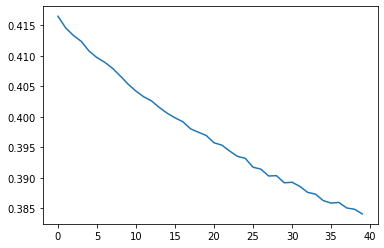

In [0]:
import matplotlib.pyplot as plt

# Plot training loss values
plt.plot(history.history['loss'])
plt.show()

In [0]:
# since we specified batch size, we have to rebuild model for individual sample generation wtih batch-size 1
weights = tf.train.latest_checkpoint('/content/gdrive/My Drive/training_regions_stop_3_nodropout/')
model_a = build_model(embedding_dim, rnn_units, batch_size=1)

model_a.load_weights(weights)

model_a.build(tf.TensorShape([1, None]))

In [0]:
import random
def generate_text(model, start_region, start_string):

  num_generate = 20
  input_region = region_keys[start_region]

  input_eval = [char_indices[s] for s in start_string]
  input_eval = [input_region] + input_eval
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  temperature = 0.5

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)

      predictions = tf.squeeze(predictions, 0)

      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)
      if predicted_id == char_indices['|']: # halt if reach EOL
        break
      text_generated.append(indices_char[predicted_id])

  return (start_string + ''.join(text_generated))

In [23]:
import string
for letter in string.ascii_uppercase:
  print(generate_text(model_a, "West", letter))

Anton City
Bruch
Creston
Dandon
Enitt
Fardell
Gondon
Highland
Ilen
Jencho
Kanson
Lake Moralet
Morrison
New River
Owing
Pillesburg
Qulon
Rockwood
Starford
Tount Lakes Bay
University
Vardelm
Walton City
Xartins
Yakesville
Zaws


In [24]:
for letter in string.ascii_uppercase:
  print(generate_text(model_a, "South", letter))

Anthonton
Berdon
Collinsville
Danall
Ecklin
Friends
Glandover
Hartham
Indian Heights
Jakesville
Kanson
Lake Morton Center
Martinsburg
Newardtown
Oakland
Pontago
Quinta
Rock City
St. John
Tengeva
University
Villa
Walton
Xontagom
Yassville
Zanisville


In [0]:
for letter in string.ascii_uppercase:
  print(generate_text(model_a, "Northeast", letter))

Amoler
Burkettsville
Cranerbeton
Dayville
Edgunsville
Fleasad
Gratson
Herding
Isganom
Juckson
Kenla Vista
Lake Melbrs
Mancula
Necta Cowm Ris
Ospood
Payson
QElmmore
Riverview
SRanton
Tourtland
University Claces
Vannaud
Waldwell
Xenia
Younezsville
Zandoll


In [25]:
for letter in string.ascii_uppercase:
  print(generate_text(model_a, "Midwest", letter))

Athima
Berville
Collingsville
Denison
Edgerton
Flatmon
Granger
Hardin
Ishia
Janesville
Kentland
Lake Montagulia
Manistee
Newark
Okala
Pennsboro
Qulon
Rocky Lake
Spring Hill
Tansilla
University Creek
Vine Point
Walton
Xayson
Yarmouth
Zonder


In [0]:
 # Region comparisons
combined_arr = np.asarray(df["city"] + df["region"])
city_arr = np.asarray(df["city"])
def compare(region):
  name_list = []
  region_match = 1
  overall_match = 0

  region_count = df['region'].value_counts()[region]
  overall_count = sum(df['region'].value_counts()) - region_count
  for i in range(1000):
    name_list.append(generate_text(model_a, region, random.choice(string.ascii_uppercase)))
  for name in name_list:
    if name + '|' + region in combined_arr:
      region_match = region_match + 1
    elif name + '|' in city_arr:
      overall_match = overall_match + 1
  print('Repeated', str(round((region_match/region_count)*100, 2)) + '%', 'cities in region')
  print('Repeated', str(round((overall_match/overall_count)*100, 2)) + '%', 'cities in other regions')

In [75]:
# Comparing shared city names in original dataset
region_cities = {}
for region in regions:
    cities_array = set()
    regionData = df[df['region']==region]
    for city in regionData['city'].to_numpy():
        cities_array.add(city)
    region_cities[region] = cities_array

for region in regions:
  other_cities = set()
  for key in region_cities.keys():
    if key != region:
      other_cities = set.union(other_cities, region_cities[key])
  shared = len(set.intersection(region_cities[region], other_cities))
  print(region + ": ", str(round(shared/len(region_cities[region]), 2)) + "%", "of cities appear in other regions")

South:  0.28% of cities appear in other regions
West:  0.27% of cities appear in other regions
Midwest:  0.33% of cities appear in other regions
Northeast:  0.32% of cities appear in other regions


In [50]:
df['region'].value_counts()

Midwest      9687
South        9615
West         5587
Northeast    3758
Name: region, dtype: int64

In [45]:
compare("West") # Compare for generated data

Repeated 3.44% cities in region
Repeated 0.56% cities in other regions


In [46]:
compare("South")

Repeated 2.83% cities in region
Repeated 0.46% cities in other regions


In [47]:
compare("Northeast")

Repeated 3.54% cities in region
Repeated 0.77% cities in other regions


In [48]:
compare("Midwest")

Repeated 2.66% cities in region
Repeated 0.49% cities in other regions
